In [1]:
import numpy as np
from scipy.constants import mu_0

from desc.equilibrium import EquilibriaFamily, Equilibrium

# from desc.examples import get
from desc.geometry import (
    FourierPlanarCurve,
    FourierRZCurve,
    FourierRZToroidalSurface,
    FourierXYZCurve,
    ZernikeRZToroidalSection,
)
from desc.grid import LinearGrid, QuadratureGrid
from desc.profiles import PowerSeriesProfile
from desc.basis import FourierZernikeBasis
from matplotlib import pyplot as plt
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_surfaces, plot_basis, plot_section
from desc.continuation import solve_continuation_automatic
from desc.optimize import Optimizer
from desc.objectives import (
    get_fixed_boundary_constraints,
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    ForceBalance,
)

DESC version 0+untagged.5740.gd083598.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 2.34 GB available memory


# Compute Test1

In [2]:
eq = Equilibrium()

B = eq.compute("B")["B"]

# Compute Test2

In [50]:
eq1 = Equilibrium(L=3, M=3, N=1, sym=None)
basis = eq1.R_basis
rlmn = np.zeros(basis.num_modes)
zlmn = np.zeros(basis.num_modes)
rlmn[basis.get_idx(0,0,0)] = 10
rlmn[basis.get_idx(1,1,0)] = 0.8
rlmn[basis.get_idx(3,1,0)] = 0.2
zlmn[basis.get_idx(1,-1,0)] = 0.8
zlmn[basis.get_idx(3,-1,0)] = -0.2
eq1.R_lmn = rlmn
eq1.Z_lmn = zlmn

In [10]:
eq = Equilibrium(L=3, M=3, N=3)
grid = LinearGrid(rho=np.linspace(0.1,1,5), M=5, N=5)
rtz = grid.nodes
rho = grid.nodes[:, 0]
theta = grid.nodes[:, 1]
a0 = 4 / 5
a1 = 1 / 5
R = 10 + (a0 * rho + a1 * (3 * rho**3 - 2 * rho)) * np.cos(theta)
Z = -(a0 * rho + a1 * (3 * rho**3 - 2 * rho)) * np.sin(theta)
eq.set_initial_guess(grid, R, Z)
B = eq.compute("B", grid=grid)["B"]
B_norm = eq.compute("|B|", grid=grid)["|B|"]
J = eq.compute("J", grid=grid)["J"]
J_norm = eq.compute("|J|", grid=grid)["|J|"]
F_norm = eq.compute("|F|", grid=grid)["|F|"]
F = eq.compute("F", grid=grid)["F"]

In [172]:
def B_ana_cal(rho_in, a0, a1, Psi0):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    return (
            Psi0
            / np.pi
            / (a0 + a1 * (3 * rho**2 - 2))
            / (a0 - 2 * a1 + 9 * a1 * rho**2)
        )

def B_vec_ana_cal(rtz, a0, a1, Psi0):
    rho = rtz[:,0]
    B = B_ana_cal(rho, a0, a1, Psi0)
    return np.stack((np.zeros_like(rho),B,np.zeros_like(rho)),axis=1)


def p_ana_cal(rho_in, a0, a1, Psi):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    term1 = (a0 - 2 * a1 + 3 * a1 * rho**2) ** 2
    term2 = (a0 - 2 * a1 + 9 * a1 * rho**2) ** 2

    result = - 1 / (2 * term1 * term2) * Psi**2 / np.pi**2 / mu_0 

    return result


def j_ana_cal(rho_in, a0, a1, Psi):
    if len(rho_in.shape)>1:
        rho_in = rho[:,0]
    else:
        rho = rho_in
    numerator = 12 * a1 * rho * (2 * a0 - 4 * a1 + 9 * a1 * rho**2)
    denominator = (3 * a1 * rho**2 + a0 - 2 * a1) ** 2 * (
        9 * a1 * rho**2 + a0 - 2 * a1
    ) ** 3

    result = numerator / denominator * Psi / np.pi / mu_0

    return result

def j_vec_ana_cal(rtz, a0, a1, Psi):
    rho = rtz[:,0]
    theta = rtz[:,1]
    j = j_ana_cal(rho, a0, a1, Psi)
    return np.stack( (-j*np.sin(theta),np.zeros_like(rho), -j*np.cos(theta)),axis=1)


def gradp_ana_cal(rho, a0, a1, Psi):
    return j_ana_cal(rho, a0, a1, Psi) * B_ana_cal(rho, a0, a1, Psi)
def gradp_vec_ana_cal(rtz,a0,a1,Psi):
    rho = rtz[:,0]
    theta = rtz[:,1]
    F = gradp_ana_cal(rho, a0, a1, Psi)
    return np.stack( (F*np.cos(theta),np.zeros_like(rho), -F*np.sin(theta)),axis=1)

In [186]:
# Norm part of force balance 
np.testing.assert_allclose(J_norm*B_norm, F_norm, atol=1e-15,rtol=1e-15)

In [187]:
B_ana = B_ana_cal(rho, a0, a1, eq.Psi)
B_vec_ana = B_vec_ana_cal(rtz, a0,a1, eq.Psi)
J_ana = j_ana_cal(rho, a0, a1, eq.Psi)
J_vec_ana = j_vec_ana_cal(rtz, a0, a1, eq.Psi)
p_ana = p_ana_cal(rho, a0, a1, eq.Psi)
gradp_ana = gradp_ana_cal(rho, a0, a1, eq.Psi)
gradp_vec_ana = gradp_vec_ana_cal(rtz, a0, a1, eq.Psi)

In [188]:
np.testing.assert_allclose(B, B_vec_ana, atol=1e-10, rtol=1e-10)
np.testing.assert_allclose(J, J_vec_ana, atol=1e-5, rtol=1e-5)
np.testing.assert_allclose(F, gradp_vec_ana, atol=1e-6,rtol=1e-10)

## Test azimuthal independence

In [116]:
grid = LinearGrid(
    rho=[0.5], theta=np.linspace(0, 2 * np.pi, 10), zeta=np.linspace(0, 2 * np.pi, 10)
)

In [67]:
from desc.compute.utils import dot

In [119]:
name = "J"
np.linalg.norm(eq.compute(name, grid=grid)[name], axis=1)

array([2045263.96160325, 2045263.96160325, 2045263.96160326,
       2045263.96160326, 2045263.96160327, 2045263.96160327,
       2045263.96160327, 2045263.96160326, 2045263.96160325,
       2045263.96160325, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160327, 2045263.96160327, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160327, 2045263.96160327,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160327,
       2045263.96160327, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160326, 2045263.96160326, 2045263.96160326,
       2045263.96160327, 2045263.96160327, 2045263.96160326,
       2045263.96160326,

In [120]:
name = "F"
np.linalg.norm(eq.compute(name, grid=grid)[name], axis=1)

array([1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.7033877 ,
       1392572.7033877 , 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338769,
       1392572.70338769, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338769, 1392572.70338769,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338769,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338768, 1392572.70338769, 1392572.70338769,
       1392572.70338769, 1392572.70338769, 1392572.70338768,
       1392572.70338768, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338768, 1392572.70338768,
       1392572.70338769, 1392572.70338769, 1392572.70338769,
       1392572.70338768,

# Compute Test 3

# Solve Test

In [2]:
Psi = 0.9
a = 1.2
R = 7
A = ((2 * Psi) / (np.pi * a**2 * (np.sqrt(2) + 1))) ** 2
p_coeff = A / 2 / mu_0

p = PowerSeriesProfile(params=[p_coeff, -p_coeff], modes=[0, 2])

iota = PowerSeriesProfile(params=[0, 0])

surf = FourierRZToroidalSurface(
    R_lmn=[R, a],
    modes_R=[[0, 0], [1, 0]],
    Z_lmn=[0, -a],
    modes_Z=[[0, 0], [-1, 0]],
    sym=False
)

In [3]:
eq = Equilibrium(
    surface=surf,
    pressure=p,
    iota=iota,
    Psi=Psi,
    NFP=1,
    L=5,
    M=3,
    N=1,
    L_grid=10,
    M_grid=6,
    N_grid=2,
    sym=False,
    method="jitable"
)

In [20]:
optimizer = Optimizer("lsq-exact")
constraints = (
    FixBoundaryR(eq=eq),  # enforce fixed  LCFS for R
    FixBoundaryZ(eq=eq),  # enforce fixed  LCFS for Z
    FixPressure(eq=eq),  # enforce that the pressure profile stay fixed
    FixIota(eq=eq),  # enforce that the rotational transform profile stay fixed
    FixPsi(eq=eq),  # enforce that the enclosed toroidal stay fixed
)
objectives = ForceBalance(eq=eq)
obj = ObjectiveFunction(objectives=objectives)

In [21]:
eq.solve(
    verbose=0,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
    maxiter=50,
);

In [12]:
eq.solve(
    verbose=0,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
    maxiter=50,
    constraints=constraints,
    optimizer=optimizer,
    objective=obj,
);

In [9]:
eq_fam = solve_continuation_automatic(
    eq,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
)

Step 1
Spectral indexing: ansi
Spectral resolution (L,M,N)=(2,1,0)
Node pattern: jacobi
Node resolution (L,M,N)=(4,2,0)
Boundary ratio = 0
Pressure ratio = 0
Perturbation Order = 2
Objective: force
Optimizer: lsq-exact
Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 3
Number of objectives: 18
Starting optimization
Using method: lsq-exact
`gtol` condition satisfied.
         Current function value: 7.858e-33
         Total delta_x: 3.117e-15
         Iterations: 1
         Function evaluations: 2
         Jacobian evaluations: 2
Start of solver
Total (sum of squares):  4.627e-33, 
Maximum absolute Force error:  2.274e-11 (N)
Minimum absolute Force error:  1.408e-12 (N)
Average absolute Force error:  6.147e-12 (N)
Maximum absolute Force error:  4.355e-18 (normalized)
Minimum absolute Force error:  2.697e-19 (normalized)
Average absolute Force error:  1.177e-18 (normalized)
End of solver
Total (sum of squares)

(<Figure size 1079.13x719.422 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

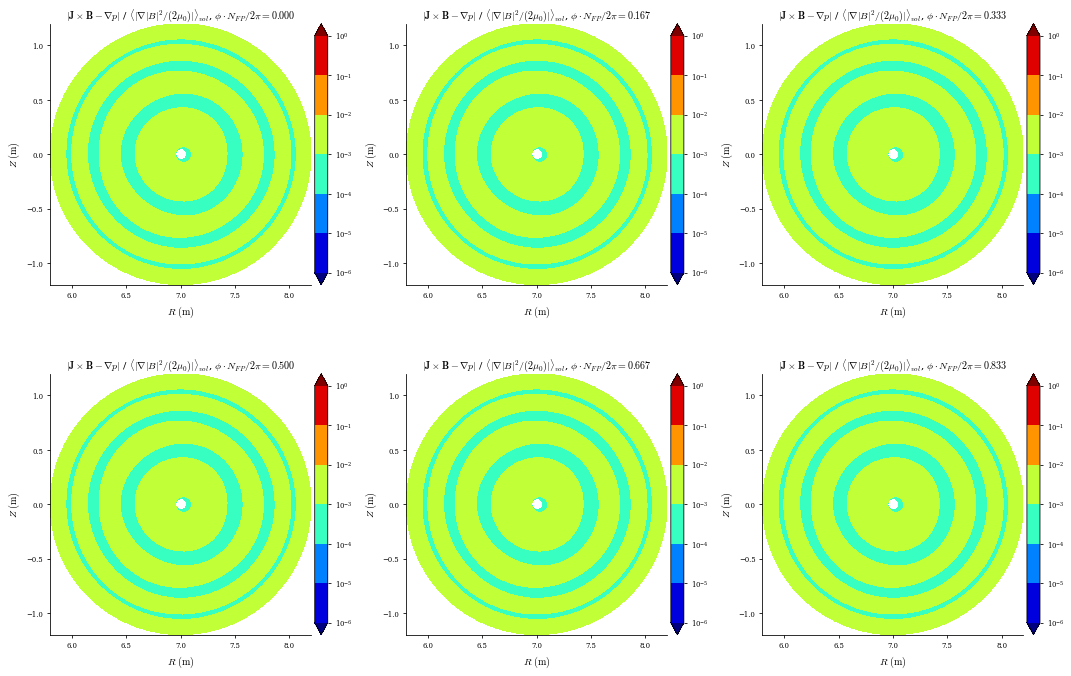

In [10]:
plot_section(eq,"|F|", norm_F=True, log=True)

(<Figure size 1079.13x719.422 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{B}|$ ($T$), $\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

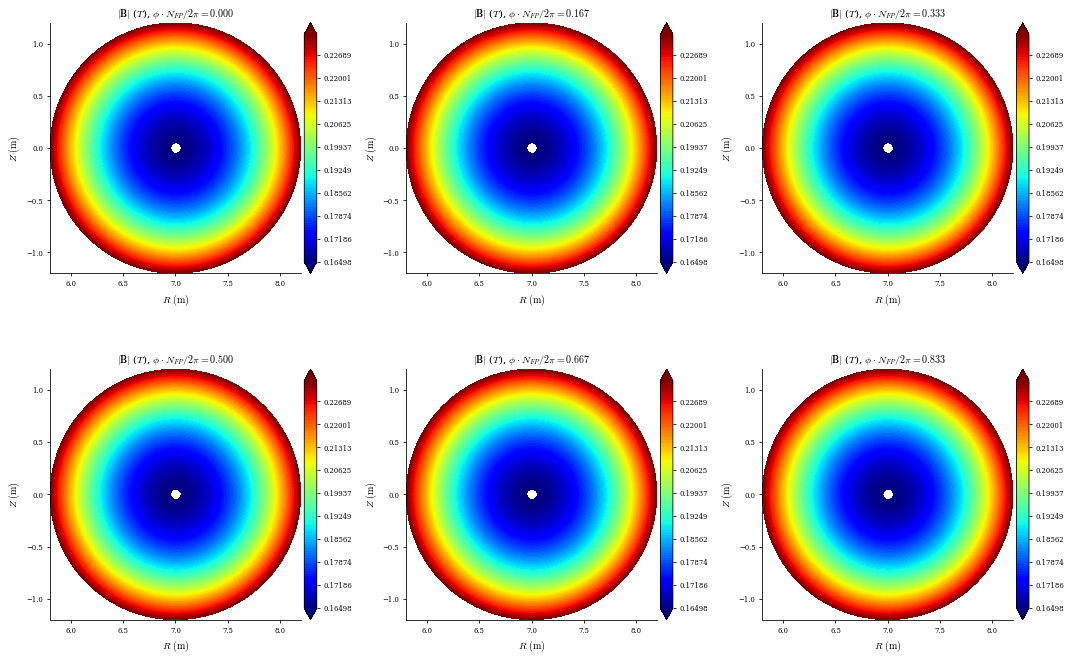

In [11]:
plot_section(eq, "|B|")

(<Figure size 863.306x719.422 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

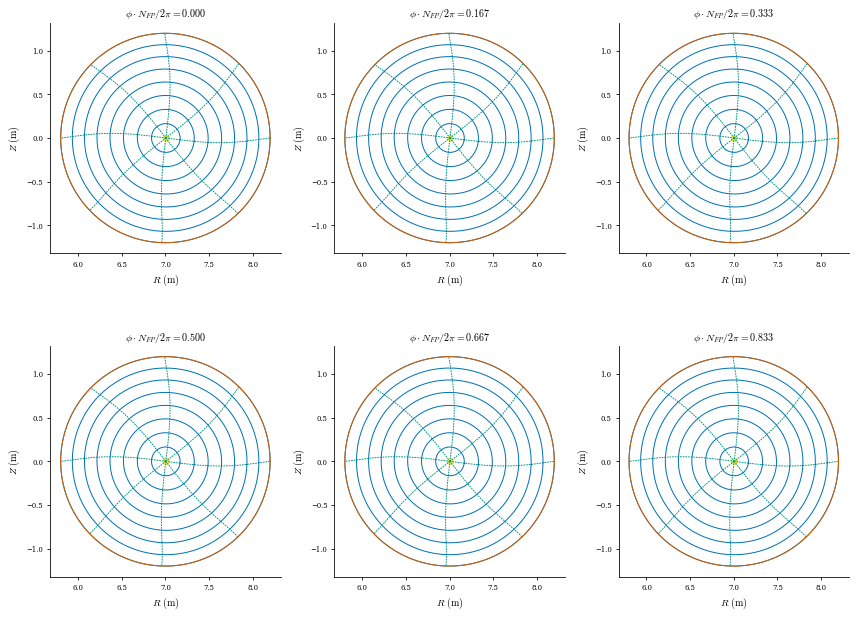

In [12]:
plot_surfaces(eq)

## verify

In [13]:
grid = LinearGrid(rho=np.linspace(0, 1, 11), theta=[np.pi * 0.0], zeta=[0])
grid = LinearGrid(rho=np.linspace(0.1, 1, 5), M=5, N=5)
data = eq.compute(["R", "Z"], grid=grid)
rho = np.linalg.norm(np.stack((data["R"] - R, data["Z"]), axis=1), axis=1)

In [14]:
def r_test(rho, a):
    return np.sqrt(np.sqrt(2) + 1) * a * np.sqrt(np.sqrt(1 + rho**2) - 1)

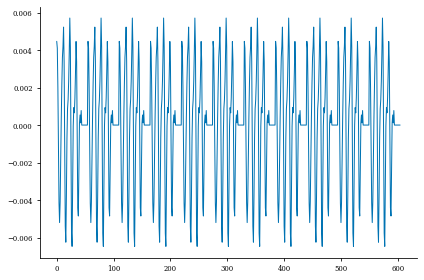

In [18]:
plt.plot(rho-r_test(grid.nodes[:, 0], a))

In [21]:
np.testing.assert_allclose(rho, r_test(grid.nodes[:, 0], a), atol=6e-3, rtol=1e-3)